In [38]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# CSDS 340 Case Study 1
*Report by Prateek Dullur and Robbie Hammond* <br>
*References and relevant packages:*<br>
1. Dr. Kevin S. Xu (for guidance and various codes) <br>
2. Seaborn - Waskom, M. et al., 2017. mwaskom/seaborn: v0.8.1 (September 2017), Zenodo.
3. XGBoost - 
Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785–794). New York, NY, USA: ACM.<br>
4. SMOTE -
N. V. Chawla, K. W. Bowyer, L. O.Hall, W. P. Kegelmeyer, "SMOTE: synthetic minority over-sampling technique," Journal of artificial intelligence research, 321-357, 2002 <br>
We also used numpy, pandas, scikit-learn, and matplotlib

# Introduction
The purpose of this report is to give detail into how our group constructed and evaluated various models to create a spam filter that was trained on the provided dataset. <br>
The algorithm that gave us the best performance was **XGBoost** with the following parameters: colsample_bytree=0.73, max_depth=4, eta=0.1, max_bin=12, n_estimators=100, objective='binary:logistic'. <br>
In this report, we will give our reasoning for choosing XGBoost and show its performance on the datasets. Of course, this algorithm was not the first one that we assessed, so this report will also give insight into other algorithms we evaluated in an exploratory fashion, and we will explain how features and hyperparameter values were selected for the evaluated algorithms. 

# Exploratory Data Analysis
First, we can import the initial training set as a pandas dataframe

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
import numpy as np
from classifySpamTest import aucCV, predictTest, tprAtFPR
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import multiprocessing
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [4]:
df = pd.read_csv('spamTrain1.csv')
df.columns = np.arange(0,31)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.0074,0.0000,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0000,0.0000,0.0036,0.0,0.0,0.0074,0.0,0.0,0.0000,0
1,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.004,0.0,0.0,...,0.0000,0.0081,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0
2,0.0000,0.0202,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0
3,0.0000,0.0000,0.0,0.0019,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0009,0.0000,0.0016,0.0,0.0,0.0000,0.0,0.0,0.0038,0
4,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0038,1


We see that there are 30 numerical features. Let us check if the classes are balanced

In [5]:
df[30].value_counts()

0    878
1    621
Name: 30, dtype: int64

The data is imbalanced. To deal with this, we will do some resampling with the SMOTE method using the package imbalance-learn. But we can do this when we actually train the classifier. First, let us look at the data visually with a correlation matrix.

<AxesSubplot:>

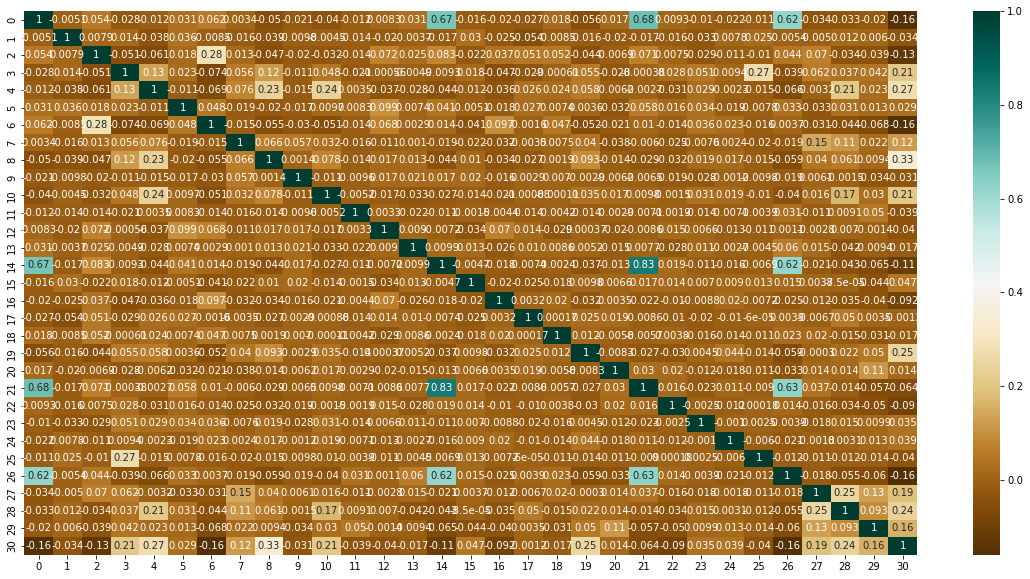

In [27]:
pl.figure(figsize=(20,10));
c= df.corr();
sns.heatmap(c,cmap="BrBG",annot=True)

This heatmap helps us get a sense of the data and what variables may be correlated. The correlations seem very sparse and minute, and it seems that a basic classifier such as a perceptron would have a difficult time. Given the number of features, a boosted decision tree ensemble may effectively set the weights of different features without overfitting too much. But to start, we will explore an SVM to get some baseline classification metrics. <br>
As mentioned earlier, we will use the SMOTE method to resamble the training data so the classes are equally balanced. This should help avoid bias in classifier training. The following output cells demonstrate GridSearchCV (10-fold) to find and train an SVM model on the best parameters. The third output shows the accuracy and TPR at FPR=0.01.

In [6]:
rus = SMOTE(random_state=1)# fit predictor and target variable

trainData = np.loadtxt('spamTrain1.csv',delimiter=',')
# Randomly shuffle rows of data set then separate labels (last column)
np.random.seed(1)
shuffleIndex = np.arange(np.shape(trainData)[0])
np.random.shuffle(shuffleIndex)
trainData = trainData[shuffleIndex,:]
trainFeatures = trainData[:,:-1]
trainLabels = trainData[:,-1]
trainFeatures, trainLabels = rus.fit_resample(trainFeatures, trainLabels)

testData = np.loadtxt('spamTrain2.csv',delimiter=',')
# Randomly shuffle rows of data set then separate labels (last column)
np.random.seed(1)
shuffleIndex = np.arange(np.shape(testData)[0])
np.random.shuffle(shuffleIndex)
testData = testData[shuffleIndex,:]
testFeatures = testData[:,:-1]
testLabels = testData[:,-1]

In [10]:
# defining parameter range
param_grid = {'C': [100, 1000], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['linear', 'rbf']} 

svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)    # verbose = 0 for readability
print("Fitting 5 folds for each of 12 candidates, totalling 60 fits")
print("10-fold cross-validation mean AUC: ", np.mean(aucCV(trainFeatures,trainLabels, model=svm)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
10-fold cross-validation mean AUC:  0.9114215232259903


In [13]:
# fitting the model for grid search
svm.fit(trainFeatures, trainLabels)
print("Best parameters:{}".format(svm.best_params_))

Best parameters:{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}


In [15]:
# get testing accuracy
clf = SVC(C=1000, gamma=1, kernel='rbf', probability=True)
# Fit classifier to training data
clf.fit(trainFeatures, trainLabels)
# Test on testing set
testOutputs = predictTest(trainFeatures,trainLabels,testFeatures, model=clf)
tpr1, _, _ = tprAtFPR(testLabels, testOutputs, 0.01)
print("Test set AUC: ", roc_auc_score(testLabels,testOutputs))
print("Test set TPR at 0.01 FPR: ", tpr1)

Test set AUC:  0.8861430688045847
Test set TPR at 0.01 FPR:  0.34554973821989526


Okay, not bad. The Naive Bayes' classifier had a test set accuracy of 0.83, so we're already seeing a significant improvement

Now let's try scaling our features before fitting a SVM model to the data. We use the StandardScalar from scikit-learn

In [16]:
# try scaling data
from sklearn.preprocessing import StandardScaler

#scale features
scaler = StandardScaler()
scaledTrainFeatures = scaler.fit_transform(trainFeatures)
scaledTestFeatures = scaler.transform(testFeatures)

#predict as before
testOutputsScaled = predictTest(scaledTrainFeatures,trainLabels,scaledTestFeatures, model=clf)
print("Test set AUC: ", roc_auc_score(testLabels,testOutputsScaled))
tpr1, _, _ = tprAtFPR(testLabels, testOutputsScaled, 0.01)
print("Test set TPR at 0.01 FPR: ", tpr1)

Test set AUC:  0.7686837195554728
Test set TPR at 0.01 FPR:  0.006980802792321117


Surprisingly, the SVM performs substantially worse on the scaled data. This may be because it is now more difficult for the SVM to find a suitable margin. Let us take a closer look at the outputs

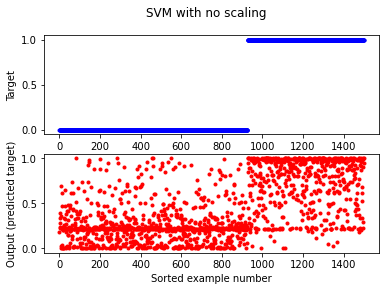

In [17]:
# Examine outputs compared to labels (code from Kevin S. Xu)
sortIndex = np.argsort(testLabels)
nTestExamples = testLabels.size
plt.subplot(2,1,1)
plt.plot(np.arange(nTestExamples),testLabels[sortIndex],'b.')
plt.xlabel('Sorted example number')
plt.ylabel('Target')
plt.suptitle('SVM with no scaling') # Added by Prateek
plt.subplot(2,1,2)
plt.plot(np.arange(nTestExamples),testOutputs[sortIndex],'r.')
plt.xlabel('Sorted example number')
plt.ylabel('Output (predicted target)')
plt.show()

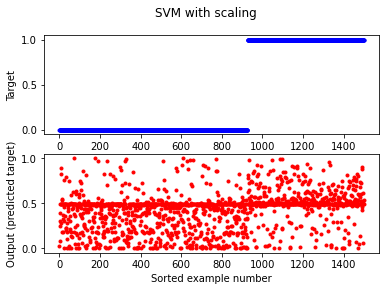

In [18]:
# Examine outputs compared to labels (code from Kevin S. Xu)
sortIndex = np.argsort(testLabels)
nTestExamples = testLabels.size
plt.subplot(2,1,1)
plt.plot(np.arange(nTestExamples),testLabels[sortIndex],'b.')
plt.xlabel('Sorted example number')
plt.ylabel('Target')
plt.suptitle('SVM with scaling')
plt.subplot(2,1,2)
plt.plot(np.arange(nTestExamples),testOutputsScaled[sortIndex],'r.')
plt.xlabel('Sorted example number')
plt.ylabel('Output (predicted target)')
plt.show()

In both cases, the SVM is not able to separate the classes as accurately as it could. It seems there is variance that is not being captured. So, let's try a random forest algorithm instead. Note that there is no need to standardize/normalize our data, since random forest is a tree-based classifier and therefore it will adjust the weights accordingly with the scales of the features.

In [25]:
# create a Gaussian Classifier
rf=RandomForestClassifier()

# Create the random grid
random_grid = {    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200, 1000]}

# Define classifier
clf = GridSearchCV(rf, random_grid, verbose=0, n_jobs=2)
# Evaluating classifier accuracy using 10-fold cross-validation
print("10-fold cross-validation mean AUC: ", np.mean(aucCV(trainFeatures,trainLabels, model=clf)))

10-fold cross-validation mean AUC:  0.9425284387764796


In [26]:
# get best parameters
clf.fit(trainFeatures, trainLabels)
print("Best parameters:{}".format(clf.best_params_))

Best parameters:{'bootstrap': True, 'max_depth': 80, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}


In [35]:
# testing accuracy
best_params = {'bootstrap': True, 'max_depth': 80, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
clf = RandomForestClassifier(**best_params)  
# Fit classifier to training data
clf.fit(trainFeatures, trainLabels)
# Test on testing set
testOutputs = predictTest(trainFeatures,trainLabels,testFeatures, model=clf)
print("Test set AUC: ", roc_auc_score(testLabels,testOutputs))
tpr1, _, _ = tprAtFPR(testLabels, testOutputs, 0.01)
print("Test set TPR at 0.01 FPR: ", tpr1)

Test set AUC:  0.8992283087743872
Test set TPR at 0.01 FPR:  0.4677137870855148


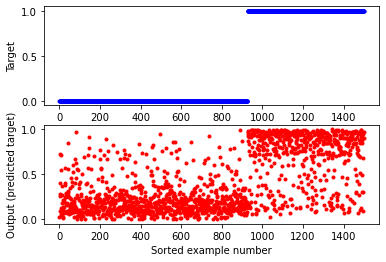

In [36]:
# Examine outputs compared to labels (code from Kevin S. Xu)
sortIndex = np.argsort(testLabels)
nTestExamples = testLabels.size
plt.subplot(2,1,1)
plt.plot(np.arange(nTestExamples),testLabels[sortIndex],'b.')
plt.xlabel('Sorted example number')
plt.ylabel('Target')
plt.subplot(2,1,2)
plt.plot(np.arange(nTestExamples),testOutputs[sortIndex],'r.')
plt.xlabel('Sorted example number')
plt.ylabel('Output (predicted target)')
plt.show()

The testing accuracy is significantly lower than the training accuracy, which could be a sign of overfitting. However, the overall testing accuracy is still a tad low. Let us try another tree-based algorithm - the XGBoost classifier. <br>
As before, we will use a GridSearchCV to find the optimal parameters. <br>
Note: in order to run this model, your python kernel will need the xgboost package, which is available through pip install xgboost

In [19]:
# Define xgb classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs=multiprocessing.cpu_count() // 2)
clf = GridSearchCV(xgb_model, {'n_estimators': [100, 200], 'eta':[0.1, 0.01], 'max_bin':[12, 128, 256],
        'colsample_bytree': [0.50, 0.75, 1]}, verbose=0, n_jobs=2)
# Evaluating classifier accuracy using 10-fold cross-validation
print("10-fold cross-validation mean AUC: ", np.mean(aucCV(trainFeatures,trainLabels, model=clf)))

10-fold cross-validation mean AUC:  0.9411412320699155


In [20]:
clf.fit(trainFeatures, trainLabels)
print("Best parameters:{}".format(clf.best_params_))

Best parameters:{'colsample_bytree': 0.5, 'eta': 0.01, 'max_bin': 12, 'n_estimators': 100}


Note that there is no need to standardize/normalize our data, since at it's core, XGBoost is an ensemble algorithm made of decision trees, and decision tree models do not benefit from feature scaling.

In [30]:
# train and test XGBoost
rus = SMOTE(random_state=1)
trainData = np.loadtxt('spamTrain1.csv',delimiter=',')
# Randomly shuffle rows of data set then separate labels (last column)
np.random.seed(1)
shuffleIndex = np.arange(np.shape(trainData)[0])
np.random.shuffle(shuffleIndex)
trainData = trainData[shuffleIndex,:]
trainFeatures = trainData[:,:-1]
trainLabels = trainData[:,-1]
trainFeatures, trainLabels = rus.fit_resample(trainFeatures, trainLabels)

testData = np.loadtxt('spamTrain2.csv',delimiter=',')
# Randomly shuffle rows of data set then separate labels (last column)
np.random.seed(1)
shuffleIndex = np.arange(np.shape(testData)[0])
np.random.shuffle(shuffleIndex)
testData = testData[shuffleIndex,:]
testFeatures = testData[:,:-1]
testLabels = testData[:,-1]

clf = xgb.XGBClassifier(colsample_bytree=0.75, max_depth=4, eta=0.1, max_bin=12, n_estimators=100, objective='binary:logistic')    
# Fit classifier to training data
clf.fit(trainFeatures, trainLabels)
# Test on testing set
testOutputs = predictTest(trainFeatures,trainLabels,testFeatures, model=clf)
print("Test set AUC: ", roc_auc_score(testLabels,testOutputs))
tpr1, _, _ = tprAtFPR(testLabels, testOutputs, 0.01)
print("Test set TPR at 0.01 FPR: ", tpr1)

Test set AUC:  0.912970587626207
Test set TPR at 0.01 FPR:  0.42757417102966844


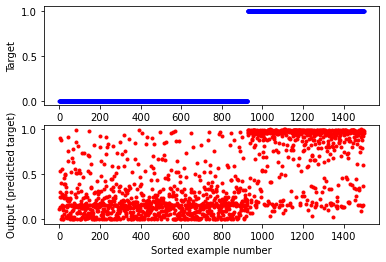

In [60]:
# Examine outputs compared to labels (code from Kevin S. Xu)
sortIndex = np.argsort(testLabels)
nTestExamples = testLabels.size
plt.subplot(2,1,1)
plt.plot(np.arange(nTestExamples),testLabels[sortIndex],'b.')
plt.xlabel('Sorted example number')
plt.ylabel('Target')
plt.subplot(2,1,2)
plt.plot(np.arange(nTestExamples),testOutputs[sortIndex],'r.')
plt.xlabel('Sorted example number')
plt.ylabel('Output (predicted target)')
plt.show()

The TPR at FPR=0.01 is slightly lower than random forest, but the accuracy is higher. Moreover, the visual check appears to show a more confident sorting between classes compared to random forest. Thus, we pick XGBoost as our best algorithm.

Let us now see if feature elimination can help improve the accuracy any further. We will use the Recursive Feature Eliminator (RFECV) from scikit-learn.

Optimal number of features : 27
Optimal features: [ True  True  True  True  True False  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True]


/Users/prateekdullur/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


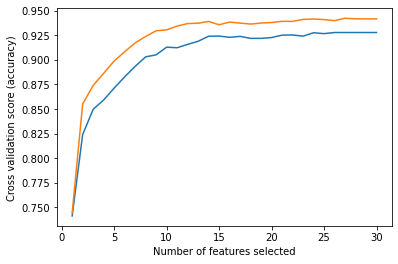

In [32]:
# Define xgb classifier
clf = xgb.XGBClassifier(max_depth=4, eta=0.1, max_bin=256, n_estimators=100, objective='binary:logistic')
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(2),
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(trainFeatures, trainLabels)

print("Optimal number of features : %d" % rfecv.n_features_)
print("Optimal features: {}".format(rfecv.support_))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [33]:
# Classifier performance with feature selection
trainFeaturesRFE = rfecv.fit_transform(trainFeatures, trainLabels)
testFeaturesRFE = rfecv.transform(testFeatures)
clf.fit(trainFeaturesRFE, trainLabels)
# Test on testing set
testOutputs = predictTest(trainFeaturesRFE,trainLabels,testFeaturesRFE, model=clf)
print("Test set AUC: ", roc_auc_score(testLabels,testOutputs))
tpr1, _, _ = tprAtFPR(testLabels, testOutputs, 0.01)
print("Test set TPR at 0.01 FPR: ", tpr1)

Test set AUC:  0.9150734885752422
Test set TPR at 0.01 FPR:  0.4223385689354276


Despite it appearing like there is an optimal number of features, the accuracy doesn't change too much whereas the TPR drops by about 0.05. Based on these results, we will refrain from using feature elimination as it appears to have mixed results on the performance of the algorithm.

# Discussion 

XGBoost is a very popular gradient-boosted tree classifier that has been used by numerous groups to find success in classification competitions (https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions). XGBoost uses tree ensembles just like random forest. However, unlike the bagging method used by random forest, XGBoost uses gradient boosting to train the trees, which can result in increased speed and efficiency. However, since bagging and boosting do use the same model structure, it is highly likely that the results from random forest could be comparable to the fully tuned XGBoost given enough fine tuning - that is an area for further exploration.

##### Other notes:
While training and evaluating the model, we discovered the XGBoost seemed to overfit the data (as evidenced by low TPR at FPR=0.01 and low test accuracy compared to training accuracy). We addressed this by tuning the colsample_bytree parameter to 0.73 instead of 1, which increased the TPR. <br>
Furthermore, we also tried random undersampling instead of SMOTE as a method of addressing the class imbalance. We found that in all tested cases, SMOTE produced a higher classifier performance.
<br>
Finally, we did also test XGBoost on a larger dataset (train on 70% of the total data points, test on the remaining 30%). We observed the accuracy to be: <br>
Test set AUC: 0.9383390811221339 <br>
TPR at FPR = 0.01: 0.5805739514348786

# Real-World Evaluation

Properties of an optimal spam filter in the real world would be one that recognizes all spam emails as spam, but never sends non-spam emails to the spam folder. In other words, the filter should have an extremely high true positive rate and an extremely low false positive rate. However, it is arguably more important that a spam filter prioritize a maintaining low false positive rate over having a high true positive rate, as sending a non-spam email to the spam folder could result in someone missing critical information, while a spam email not being filtered typically just results in a minor annoyance. To evaluate the effectiveness of a spam filter, one must consider both the true positive and false positive rates, but with more focus put on the false positive rate. As such, considering the true positive rate at a low false positive rate (such as 1% as done in this assignment, or even lower) may be an effective way to evaluate our classifier in relation to other options. 

Exactly how important it is for the filter to avoid classifying non-spam as spam depends on the individual user, so to create the best spam filter possible, it would be important to include an "aggressiveness" setting, which can be set by the user. This setting would affect the false positive rate of the filter, and could be implemented by using multiple models for different filters. The most aggressive filter would likely have a higher false positive rate (as it would air on the side of sending things to spam) while the least aggressive setting would likely have a lower false positive rate (as it would air on the side of not sending things to spam).

To improve the spam filter further, a feature could be implemented such that when a spam email is opened, responded to, or manually sent to the user's primary inbox, information is sent back to the organization responsible for the filter, indicating that this email should be considered a false positive. Similarly, when an email is manually sent to the spam folder, it is recognized as a false negative. This information could be used to get real-world statistics regarding how the filter is performing. One could also create a system that requests users to share feedback with the organization by taking a short survey, as is done in many contemporary applications. Nonetheless, this user data and feedback could be used to fine-tune the model to further improve performance.